In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class CombinedModel(nn.Module):
	def __init__(self, num_classes=4):
		super(CombinedModel, self).__init__()
		
		self.convnext = models.convnext_small(pretrained=True)
		self.convnext2 = models.convnext_small(pretrained=True)
		self.convnext3 = models.convnext_small(pretrained=True)
		self.convnext4 = models.convnext_small(pretrained=True)

		# Replace the classifiers with identities to extract features
		self.convnext.classifier[2] = nn.Identity()
		self.convnext2.classifier[2] = nn.Identity()
		self.convnext3.classifier[2] = nn.Identity()
		self.convnext4.classifier[2] = nn.Identity()
		
		self.fc = nn.Sequential(
			nn.Linear(7168  , 512),
			nn.Dropout(0.2),
			nn.ReLU(),
			nn.Linear(512, num_classes)
		)

	def forward(self, image,image2):
		B, C, H, W = image.size()
		
		if H % 2 != 0 or W % 2 != 0:
			raise ValueError("Image height and width must be divisible by 2.")
		
		top_left = image[:, :, :H//2, :W//2]
		top_right = image[:, :, :H//2, W//2:]
		bottom_left = image[:, :, H//2:, :W//2]
		bottom_right = image[:, :, H//2:, W//2:]
		
		features1 = self.convnext(top_left)
		features2 = self.convnext2(top_right)
		features3 = self.convnext3(bottom_left)
		features4 = self.convnext4(bottom_right)
		
		combined_features = torch.cat((features1, features2, features3, features4), dim=1)
		
		output = self.fc(combined_features.view(combined_features.size(0), -1))
		
		return output




In [2]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2 as cv

transform = transforms.Compose([
	transforms.Resize((448, 448)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

class CustomImageDataset(Dataset):
	def __init__(self, image_dir, transform=None):
		self.image_dir = image_dir
		self.transform = transform
		self.image_labels = []
		for folder in os.listdir(image_dir):
			if '1' in folder:
				label = 0
			elif '2' in folder:
				label = 1
			elif '4' in folder:
				label = 2
			else:
				label = 3

			for sub_folder in tqdm(os.listdir(os.path.join(image_dir, folder))):
				files = os.listdir(os.path.join(image_dir, folder, sub_folder))
				if len(files) == 2:
					if 'CC' in files[0]:
						file1 = os.path.join(image_dir, folder, sub_folder, files[0])
						file2 = os.path.join(image_dir, folder, sub_folder, files[1])
					else:
						file1 = os.path.join(image_dir, folder, sub_folder, files[1])
						file2 = os.path.join(image_dir, folder, sub_folder, files[0])
				else:
					file1 = os.path.join(image_dir, folder, sub_folder, files[0])
					file2 = os.path.join(image_dir, folder, sub_folder, files[0])

				image1PIL = cv.imread(file1)
				image2PIL = cv.imread(file2)
				
				combined_image = cv.hconcat([image1PIL, image2PIL])
				label = int(label)  
				combined_image = Image.fromarray(combined_image)
				if self.transform:
					image1 = self.transform(combined_image)
				
				self.image_labels.append((image1, image1, label))
	
	def __len__(self):
		return len(self.image_labels)
	
	def __getitem__(self, idx):
		image1, image2, label = self.image_labels[idx]
		
		
		return image1, image2, label


trainPath = "./Data-448/"
valPath = "./Data-448-Val/"

print("Creating Custom Data")
train_dataset = CustomImageDataset(image_dir=trainPath, transform=transform)
val_dataset = CustomImageDataset(image_dir=valPath, transform=transform)
# test_dataset = CustomImageDataset(image_dir=testPath, transform=transform)

def get_batches(dataset, batch_size, shuffle=True):
	indices = np.arange(len(dataset))
	if shuffle:
		np.random.shuffle(indices)
	for start_idx in range(0, len(dataset), batch_size):
		batch_indices = indices[start_idx:start_idx + batch_size]
		batch = [dataset[idx] for idx in batch_indices]
		image1s,image2s, labels = zip(*batch)
		image1s = torch.stack(image1s)
		image2s = torch.stack(image2s)
		labels = torch.tensor(labels)
		yield image1s,image2s, labels


Creating Custom Data


100%|██████████| 25/25 [00:00<00:00, 157.23it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train = [label for _, _, label in train_dataset]
device = torch.device(3)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(class_weights)
model = CombinedModel(num_classes=4)

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

print(torch.cuda.device_count())


   
def train_model(model, train_dataset, val_dataset, criterion, optimizer, num_epochs=10, batch_size=16):
    
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        
        for i, (image1s,image2s, labels) in enumerate(get_batches(train_dataset, batch_size, shuffle=True)):
            image1s,image2s, labels = image1s.to(device),image2s.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(image1s,image2s)
            labels = labels.long()  # Ensure labels are LongTensor
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            # Print loss for this batch
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}, Loss: {loss.item():.6f}')
            
            running_loss += loss.item() * image1s.size(0) 

        # Calculate and print average loss for this epoch
        epoch_loss = running_loss / len(train_dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}')
        
        # Validation (optional, to track performance on validation data)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for image1s,image2s, labels in get_batches(val_dataset, batch_size, shuffle=False):
                image1s,image2s, labels = image1s.to(device),image2s.to(device), labels.to(device)
                outputs = model(image1s,image2s)
                labels = labels.long()  # Ensure labels are LongTensor
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * image1s.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = correct / total * 100
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        torch.save(model.state_dict(), './Models/model' + str(epoch) + '.pt')

train_model(model, train_dataset, val_dataset, criterion, optimizer, num_epochs=20, batch_size=32)


<>:11: SyntaxWarning: invalid escape sequence '\M'
<>:11: SyntaxWarning: invalid escape sequence '\M'
C:\Users\medicai\AppData\Local\Temp\ipykernel_21948\2840706684.py:11: SyntaxWarning: invalid escape sequence '\M'
  model.load_state_dict(torch.load('.\Models\model9.pt', map_location=device))
c:\Users\medicai\anaconda3\envs\nlp_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\medicai\anaconda3\envs\nlp_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\medicai\AppData\Local\Tem

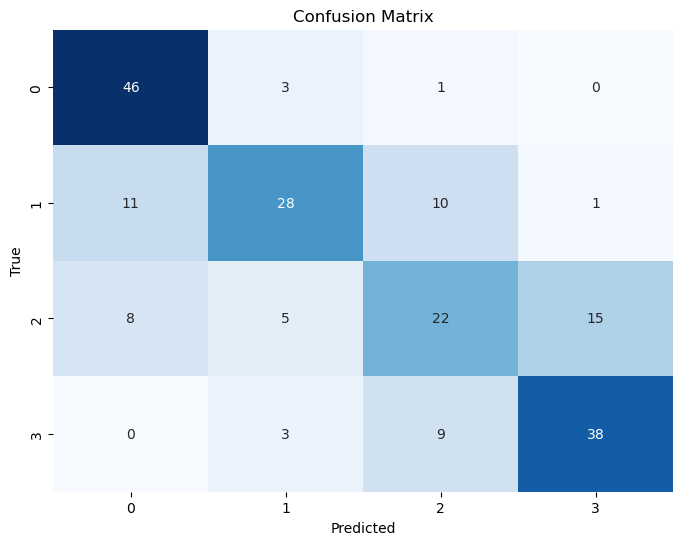

F1 Score: 0.6596


(array([[46,  3,  1,  0],
        [11, 28, 10,  1],
        [ 8,  5, 22, 15],
        [ 0,  3,  9, 38]], dtype=int64),
 0.6595608958701288)

In [14]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model = CombinedModel(num_classes=4)
device = torch.device(3)
model.to(device)

# Load the model weights
model.load_state_dict(torch.load('.\Models\model9.pt', map_location=device))
def evaluate_model(model, testData, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for image1s,image2s, labels in get_batches(testData, 8, shuffle=False):
            image1s, labels = image1s.to(device), labels.to(device)
            outputs = model(image1s,image2s)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # Compute F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'F1 Score: {f1:.4f}')

    return cm, f1

evaluate_model(model, val_dataset, device)


In [ ]:
#0.6596 9